## Import modules and Load Data

In [2]:
# Import modules
import os
import csv
import cv2
import numpy as np
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Cropping2D, Lambda
import matplotlib.pyplot as plt
%matplotlib inline

In [114]:
# Load csv files
steer_angels = []
center_path = []
left_path = []
right_path = []
ANGEL_OFFSET = 0.24

with open('data/driving_log.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for line in reader:
        steer_angels.append(float(line['steering']))
        center_path.append('data/' + line['center'])
        left_path.append('data/' + line['left'].split(' ')[1])
        right_path.append('data/' + line['right'].split(' ')[1])

## Data Exploration and Visulization

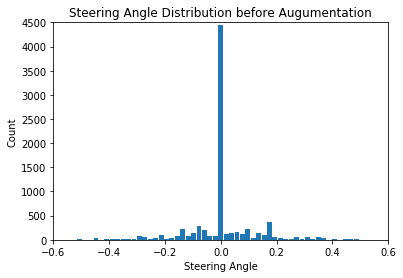

In [115]:
# Plot the histogram on training label
plt.axis([-0.6, 0.6, 0, 4500])
plt.hist(steer_angels, bins = 100, rwidth=0.9)
plt.xlabel('Steering Angle')
plt.ylabel('Count')
plt.title('Steering Angle Distribution before Augumentation')
plt.show()

In [116]:
# Remove 15% zero-steering-angel data
new_steer_angels = []
new_center_path = []
new_left_path = []
new_right_path = []
# left_path_idx = []
# right_path_idx = []
for i in range(0, len(steer_angels)):
    angel = steer_angels[i]
    center = center_path[i]
    left = left_path[i]
    right = right_path[i]
    if abs(angel) <= 0.01:
        if np.random.uniform() >= 0.85:
            new_steer_angels.append(angel)
            new_center_path.append(center)
            new_left_path.append(left)
            new_right_path.append(right)
    else:
        new_steer_angels.append(angel)
        new_center_path.append(center)
        new_left_path.append(left)
        new_right_path.append(right)
        
steer_angels = new_steer_angels
center_path = new_center_path
left_path = new_left_path
right_path = new_right_path
print('Length of new dataset is {}'.format(len(steer_angels)))

Length of new dataset is 4261


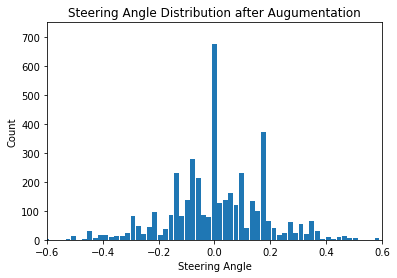

In [117]:
# Plot the histogram on training label after removing 85% zero angels
plt.axis([-0.6, 0.6, 0, 750])
plt.hist(new_steer_angels, bins = 100, rwidth=0.9)
plt.xlabel('Steering Angle')
plt.ylabel('Count')
plt.title('Steering Angle Distribution after Augumentation')
plt.show()

In [118]:
# Split training and validation dataset
center_path, left_path, right_path, steer_angels = shuffle(center_path, left_path, right_path, steer_angels)
img_train, img_val, angel_train, angel_val = train_test_split(center_path, steer_angels, test_size = 0.2, random_state = 0)

In [79]:
# Load and transform image into GRB format
def load_img(img):
    img = cv2.imread(img)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img

In [80]:
# Plot left, center and right image with angels
def visualize_img(rand_idx):
    center_img = load_img(center_path[rand_idx])
    left_img = load_img(left_path[rand_idx])
    right_img = load_img(right_path[rand_idx])
    
    center_angle = steer_angels[rand_idx]
    left_angle = center_angle + ANGEL_OFFSET
    right_angle = center_angle - ANGEL_OFFSET
    
    # Plot left img
    plt.subplot(1,3,1)
    plt.imshow(left_img)
    plt.title('Left Image & Angel is {:.2f}'.format(left_angle))
    plt.axis('off')

    # Plot center img
    plt.subplot(1,3,2)
    plt.imshow(center_img)
    plt.title('Center Image & Angel is {:.2f}'.format(center_angle))
    plt.axis('off')

    # Plot right img
    plt.subplot(1,3,3)
    plt.imshow(right_img)
    plt.title('Right Image & Angel is {:.2f}'.format(right_angle))
    plt.axis('off')

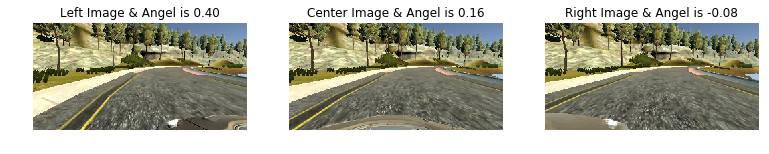

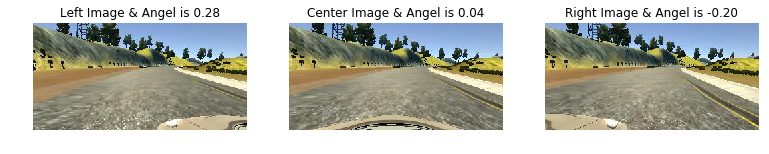

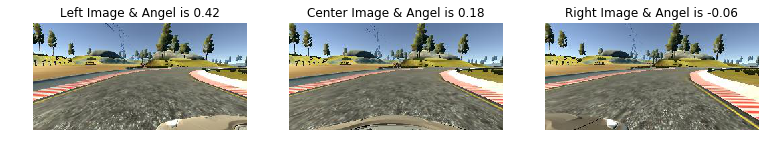

In [123]:
for index in range(3):
    rand_idx = np.random.randint(len(center_path))
    plt.figure(figsize=(13,3))
    visualize_img(rand_idx)

## Data Agumentation

In [82]:
# Randomly adjust brightness
def adjust_brightness(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    rand_brightness_coeff = 0.25 + np.random.uniform(0.3, 1) # Range [0.55, 1.25]
    img[:,:,2] = img[:,:,2] * rand_brightness_coeff
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return img

In [83]:
# Randomly flip images horizontally to combat most straight driving
def rand_flip(img, angel):
    new_img = np.array(img)
    new_angel = angel
    if np.random.randint(2) == 0:
        new_img = cv2.flip(img,1)
        new_angel = -angel
    return new_img, new_angel

In [84]:
# Randomly shift images horizontally and vertically
# http://docs.opencv.org/trunk/da/d6e/tutorial_py_geometric_transformations.html
def rand_shift(img, angel):
    rows, cols = img.shape[0:2]
    max_dx = 50
    angle_pixel = 0.003 #steering angel per pixel, add when shift to right, minus when to left
    dx = max_dx * np.random.uniform() - 0.5*max_dx #Range is [-25, 25] in x direction
    dy = 30 * np.random.uniform() - 15 #Range is [-15, 15] in y direction
    new_angel = angel + dx * angle_pixel
    M = np.float32([[1,0,dx],[0,1,dy]]) #Tranformation matrix
    dst_img = cv2.warpAffine(img, M, (cols,rows))
    return dst_img, new_angel

In [85]:
# Radomly add shadow
def rand_shadow(img):
    length_y, length_x = img.shape[0:2]
    shadow_poly = np.array(img)
    shadow_img = np.array(img)

    if np.random.randint(2) == 0:    
        x_top_left = np.random.randint(0, 0.5 * length_x)
        x_top_right = np.random.randint(0.5 * length_x, length_x)
        y_top = 0

        x_bottom_left = np.random.randint(0, 0.5 * length_x)
        x_bottom_right = np.random.randint(0.5 * length_x, length_x)
        y_bottom = length_y

        vertices = np.array([[x_top_left, y_top],[x_bottom_left, y_bottom],[x_bottom_right ,y_bottom],[x_top_right, y_top]])

        cv2.fillPoly(shadow_poly, [vertices],-1)
        alpha = np.random.uniform(0.5,0.8)
        gamma =  1 - alpha
        cv2.addWeighted(shadow_poly, alpha, img, gamma,0, shadow_img)
    return shadow_img

In [86]:
def resize_img(img):
    rows, cols = img.shape[0:2]
    # Remove the top 40 pixels and the bottom 20 pixels
    resized_img = img[60:140, 0:cols, :]
    return resized_img

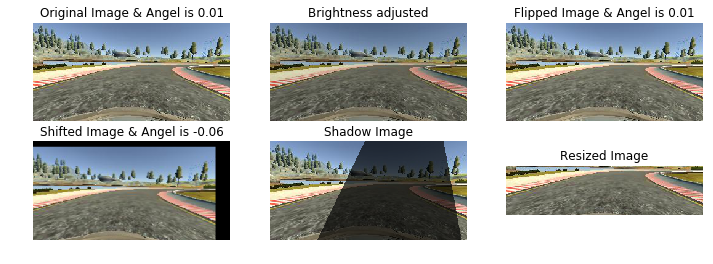

In [130]:
rand_idx = np.random.randint(len(steer_angels))
ref_img = load_img(center_path[rand_idx])
ref_angel = steer_angels[rand_idx]
bright_img = adjust_brightness(ref_img)
flip_img, flip_angel = rand_flip(ref_img, ref_angel)
shift_img, shift_angel = rand_shift(ref_img, ref_angel)
shadow_img = rand_shadow(ref_img)
resized_img = resize_img(ref_img)
# Original
plt.figure(figsize=(12,4))
plt.subplot(2,3,1)
plt.imshow(ref_img)
plt.axis('off')
plt.title('Original Image & Angel is {:.2f}'.format(ref_angel))


# Brightness adjusted
plt.subplot(2,3,2)
plt.imshow(bright_img)
plt.axis('off')
plt.title('Brightness adjusted')

# Flipped
plt.subplot(2,3,3)
plt.imshow(flip_img)
plt.axis('off')
plt.title('Flipped Image & Angel is {:.2f}'.format(flip_angel))

# Shifted
plt.subplot(2,3,4)
plt.imshow(shift_img)
plt.axis('off')
plt.title('Shifted Image & Angel is {:.2f}'.format(shift_angel))

# Shadow
plt.subplot(2,3,5)
plt.imshow(shadow_img)
plt.axis('off')
plt.title('Shadow Image')

# Resized
plt.subplot(2,3,6)
plt.imshow(resized_img)
plt.axis('off')
plt.title('Resized Image')

In [88]:
def generate_training_data():
    rand_number = np.random.randint(len(steer_angels))
    
    rand_idx = np.random.randint(3)
    if rand_idx == 0:
        img = load_img(center_path[rand_number])
        angel = steer_angels[rand_number]
    elif rand_idx == 1:
        img = load_img(left_path[rand_number])
        angel = steer_angels[rand_number] + ANGEL_OFFSET
    else:
        img = load_img(right_path[rand_number])
        angel = steer_angels[rand_number] - ANGEL_OFFSET
        
    img = adjust_brightness(img)
    img, angel = rand_flip(img, angel)
    img, angel = rand_shift(img, angel)
    img = rand_shadow(img)
    img = resize_img(img)
    return img, angel

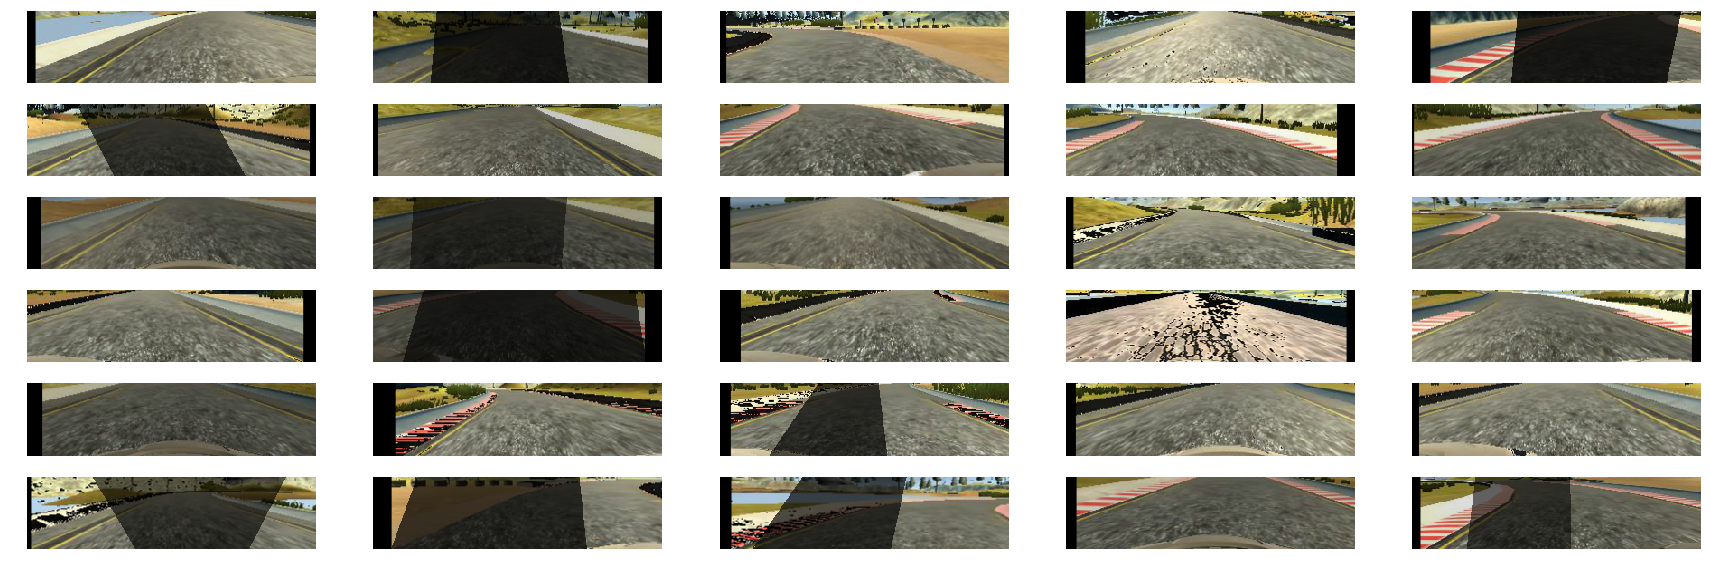

In [131]:
plt.figure(figsize=(30,10))
for i in range(30):
    img, angel = generate_training_data()
    plt.subplot(6,5,i+1)
    plt.imshow(img)
    plt.axis('off')

## Convolutional Neural Network Model